# Projections onto the canonical simplex with additional linear inequalities

This repository is a complementary material to our paper ["Projections onto the canonical simplex with additional linear inequalities"](https://arxiv.org/), where we consider projections coming from the fields of distributionally robust optimization (DRO1 and DRO2).

For the implementation, see the original [package](https://github.com/VaclavMacha/Projections/tree/develop).

## Preliminaries

This notebook and the codes can be accessed without any installations. To change the codes, it is necessary to install [Julia](https://julialang.org/downloads/) (tested for version 1.2.0), the [Projection](https://github.com/VaclavMacha/Projections/tree/develop) package and some standard packages such as `Random` or `Plots`. The `Projection` package can be installed using pkg REPL as follows

```julia
(v1.2) pkg> add https://github.com/VaclavMacha/Projections.git#develop
```

After doing so, we load the packages and set the seed and tolerances by running

In [1]:
using Projections
using Plots, Random, Distributions, LinearAlgebra

Random.seed!(12);
atol = 1e-8;

## 1. Problem (DRO1)

Problem (DRO1) stems from the distributinally robust optimization and reads

$$
\begin{alignat}{2}
    \mathrm{maximize}
        \quad & \mathbf{c}^\top \mathbf{p} \\
    \mathrm{subject\ to}
        \quad & \sum_{i=1}^n p_i=1, \\
        \quad & 0 \le p_i, \quad \forall i = 1, \dots, n,\\
        \quad & \sum_{i=1}^n q_i \phi\left(\frac{p_i}{q_i}\right) \le \varepsilon.
\end{alignat}
$$

For the detailed problem derivation, please refer to our paper.

### 1.2. Time comparison
We provide the time complexity of the presented algorithms. Denoting $n$ to be the length of $\mathbf{q}$, we consider $n \in [10^{2},10^{5}]$.

In [2]:
l = 2:0.25:5;
N = ceil.(Int64, 10 .^l);

function model_DRO(n::Int, d, ε::Real = 0.1)
    q   = rand(n)
    q ./= sum(q)
    c   = rand(Distributions.Normal(0,1), n)
    
    return DRO(d, q, c, ε)
end

model_DRO (generic function with 2 methods)

For each $n$ we randomly generate data, solve (DRO1) twenty times and average the execution times.

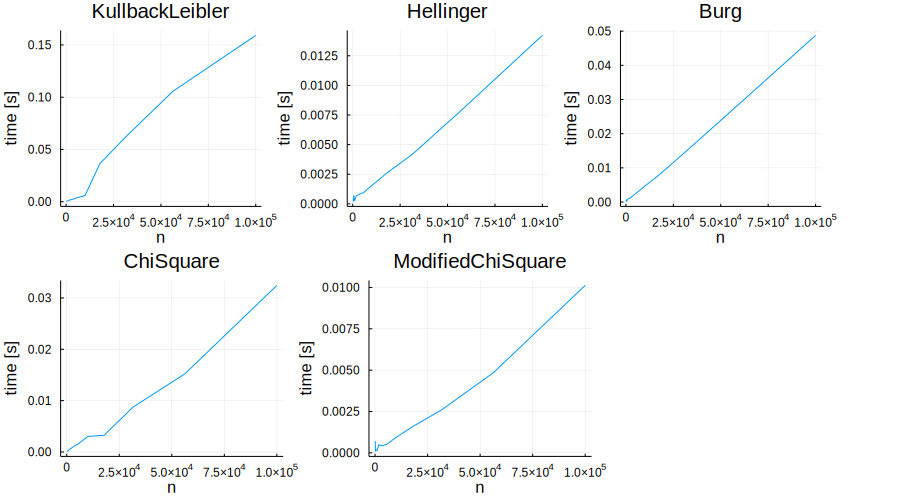

In [3]:
plots = Any[]
for d in [KullbackLeibler(), Hellinger(), Burg(), ChiSquare(), ModifiedChiSquare()]
    table = benchmark(Sadda(), (n) -> model_DRO(n, d), N; maxevals = 20, verbose = false)

    push!(plots, plot(table.dimension, table.evaltime_mean, title = string(typeof(d).name)))
end

plot(plots..., display = true,
               layout  = @layout([a{0.3w} b{0.3w} c{0.3w}; d{0.3w} e{0.3w}]),
               size    = (900, 500),
               legend  = false,
               xlabel  = "n",
               ylabel  = "time [s]")

## 2. Problem (DRO2)

Problem (DRO2) stems from the distributinally robust optimization and reads

$$
\begin{alignat}{2}
    \mathrm{maximize}
        \quad & \mathbf{c}^\top \mathbf{p} \\
    \mathrm{subject\ to}
        \quad & \sum_{i=1}^n p_i=1, \\
        \quad & 0 \le p_i, \quad \forall i = 1, \dots, n,\\
        \quad & \| \mathbf{p} - \mathbf{q}\|_{p} \le \varepsilon.
\end{alignat}
$$

For the detailed problem derivation, please refer to our paper.

### 2.1. Solution properties

Since the problem does not depend on the order of the components of $\mathbf{p}$, without loss of generality we assume that $\mathbf{c}$ is sorted. First, we generate random data and then compute the optimal solution for problem (DRO2).

In [4]:
n = 20;
q = ones(n)/n;
c = sort(rand(Distributions.Normal(0,1), n));
ε = 0.05;

To check whether our solution is correct, we compare it with the solution given by the [Ipopt](https://www.coin-or.org/Ipopt/documentation/) or [CPLEX](https://www.ibm.com/products/ilog-cplex-optimization-studio) solver. To keep the presentation simple, we compare results only for the $l_{1}$ norm, where we use the `CPLEX` solver.

In [5]:
p_l1    = solve(Sadda(), DRO(Lone(), q, c, ε));
p_cplex = solve(General(), DRO(Lone(), q, c, ε));

print(string("‖p_l1 - p_cplex‖ = ", LinearAlgebra.norm(p_l1 .- p_cplex)))

‖p_l1 - p_cplex‖ = 2.306595211858756e-16

Now we plot the obtained solutions for all three norms. Since $\mathbf{p}$ is a probability distribution, an increase in one component has to lead to a decrease in another. Since the objective is linear, the solution will have large values of $p_i$ whenever $c_i$ is small and small values of $p_i$ whenever $c_i$ is large. This is shown in the next graph. Recall that $\mathbf{p}^{0}$ follows the uniform distribution and that $\mathbf{c}$ is sorted. It is interesting to observe the values of $\mathbf p$ for different norms. While the $l_1$ and $l_\infty$ norms lead to significant deviations from $\mathbf q$, the $l_2$ norm leads to a more balanced solution. This suggests to use the $l_2$ distance in the distributionally robust optimization.

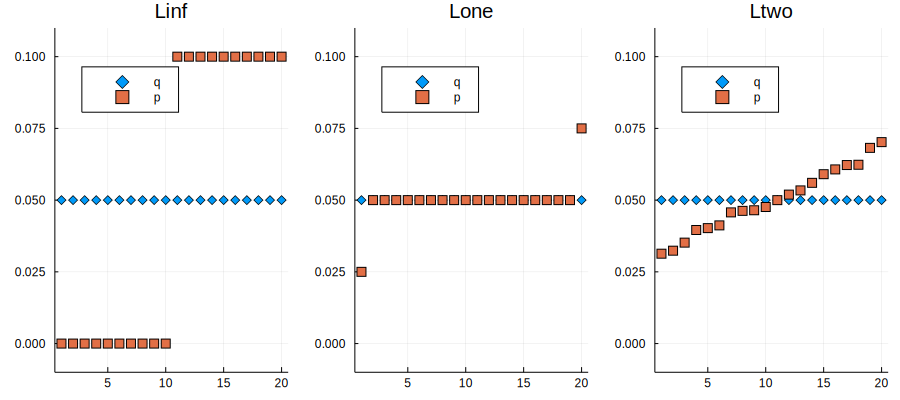

In [6]:
ylims = Float64[]
plots = Any[]
for d in [Linf(), Lone(), Ltwo()]
    p = solve(Sadda(), DRO(d, q, c, ε));

    f = plot(legend = :topleft, title = string(typeof(d).name))
    scatter!(1:n, q, label = "q", marker = :diamond)
    scatter!(1:n, p, label = "p", marker = :rect)

    push!(ylims, extrema(p)...)
    push!(plots, f)
end

plot(plots..., display = true,
               layout  = (1,3),
               size    = (900, 400),
               ylims   = extrema(ylims) .+ (-0.01, +0.01))

### 2.2. Time comparison
We provide the time complexity of the presented algorithms. Denoting $n$ to be the length of $\mathbf{q}$, we consider $n \in [10^{2},10^{5}]$.

In [7]:
l = 2:0.25:5;
N = ceil.(Int64, 10 .^l);

function model_DRO(n::Int, d, ε::Real = 0.1)
    q   = rand(n)
    q ./= sum(q)
    c   = rand(Distributions.Normal(0,1), n)
    
    return DRO(d, q, c, ε)
end

model_DRO (generic function with 2 methods)

For each $n$ we randomly generate data, solve (DRO2) twenty times and average the execution times.

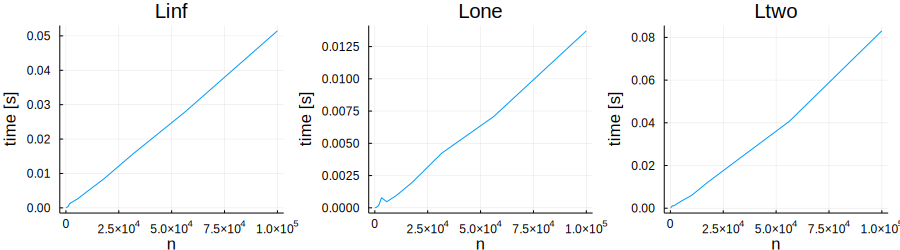

In [8]:
plots  = Any[]
for d in [Linf(), Lone(), Ltwo()]
    table = benchmark(Sadda(), (n) -> model_DRO(n, d), N; maxevals = 20, verbose = false)
    
    f = plot(table.dimension, table.evaltime_mean, title = string(typeof(d).name))
    push!(plots, f)
end

plot(plots..., display = true,
               layout  = (1,3),
               size    = (900, 250),
               legend  = false,
               xlabel  = "n",
               ylabel  = "time [s]")

In the figure above we see (almost) linear dependence of time on the data size $n$. For the $l_{2}$ norm we provide the comparison of our method and the algorithm from [[Philpott 2018]](https://link.springer.com/article/10.1007/s10287-018-0314-0). The computational complexity of `Phillpot` is quadratic and the running time is much higher than ours. 

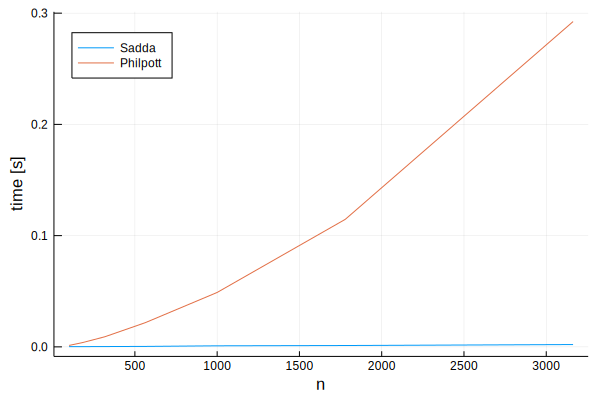

In [9]:
l = 2:0.25:3.5;
N = ceil.(Int64, 10 .^l);

plot()
for solver in [Sadda(), Philpott()]
    table = benchmark(solver, (n) -> model_DRO(n, Ltwo()), N; maxevals = 20, verbose = false)
 
    plot!(table.dimension, table.evaltime_mean, label = string(typeof(solver).name))
end

plot!(display = true,
      legend  = :topleft,
      size    = (600, 400),
      xlabel  = "n",
      ylabel  = "time [s]")